# Chapter 1: GemPy Basic

In this first example, we will show how to construct a first basic model and the main objects and functions. First we import gempy:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
# prepend to list to get correct gempy version
sys.path.insert(0,"../")
# sys.path.append("../")


# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
../gempy/UncertaintyAnalysisPYMC2.py:8: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


In [3]:
import pyevtk

In [4]:
gp.__path__

['../gempy']

In [226]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 100,100,100],
                          path_f = os.pardir+"/input_data/FW_Foliations.csv", 
                          path_i = os.pardir+"/input_data/FW_Points.csv")


../gempy/DataManagement.py:438: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../gempy/DataManagement.py:441: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


In [227]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest": ('SecondaryReservoir','Seal', 'Reservoir', 'Overlying')},
                       order_series = ["fault", 'Rest'],
                       order_formations=['MainFault', 
                                         'SecondaryReservoir', 'Seal','Reservoir', 'Overlying',
                                         ], verbose=0) 

../gempy/DataManagement.py:438: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.interfaces["series"] = [(i == _series).sum().argmax() for i in self.interfaces["formation"]]
../gempy/DataManagement.py:441: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  self.foliations["series"] = [(i == _series).sum().argmax() for i in self.foliations["formation"]]


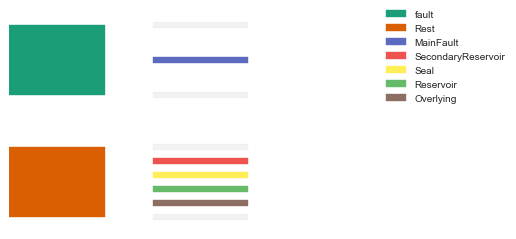

In [228]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

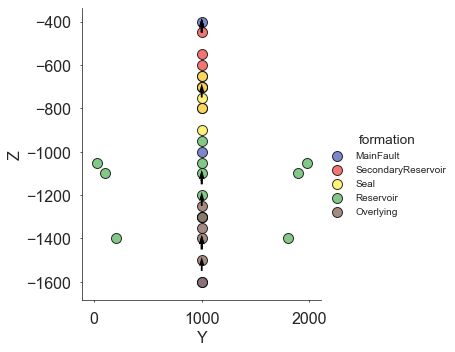

In [373]:
%matplotlib inline
gp.plot_data(geo_data, direction='x')

In [374]:
gp.plot_data_3D(geo_data)

In [230]:
interp_data = gp.InterpolatorInput(geo_data, u_grade=[3,0], dtype="float64")
print(interp_data)

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [207]:
import copy
#init = copy.deepcopy(interp_data.geo_data_res)

In [208]:
#interp_data.geo_data_res = init

In [209]:
lith_block, fault_block = gp.compute_model(interp_data)

In [13]:
 # Testing the uncertainty
np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.01*\
np.random.choice([-1,1],size = interp_data.geo_data_res.interfaces['Z'].shape[0] )

array([-0.01, 0.01, 0.01, 0.01, 0.01, 0.01, -0.01, -0.01, 0.01, -0.01,
       -0.01, 0.01, 0.01, -0.01, -0.01, -0.01, 0.01, 0.01, -0.01, 0.01,
       0.01, -0.01, 0.01, -0.01, 0.01, 0.01, 0.01, -0.01, 0.01, 0.01,
       -0.01, -0.01, -0.01, -0.01, 0.01, 0.01, 0.01, 0.01, -0.01],
      dtype=object)

In [231]:
## Own implementation to avoid "extreme" cases (no continues updating, always reverting to original model)
import copy 
ori_data = copy.deepcopy(interp_data.geo_data_res)


In [232]:
z_vals = ori_data.interfaces[ori_data.interfaces['formation'] == 'Reservoir']['Z']
z_vals

16    0.397536
17    0.397536
18    0.487279
19    0.512921
20    0.423177
21    0.448818
22    0.474459
23    0.487279
24    0.474459
25    0.487279
26    0.474459
Name: Z, dtype: object

In [233]:
z_vals = np.array(z_vals, dtype=np.float64)

In [234]:
# try setting values back to interp_data:
interp_data.geo_data_res.interfaces.set_value?

In [235]:
interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z']

16    0.397536
17    0.397536
18    0.487279
19    0.512921
20    0.423177
21    0.448818
22    0.474459
23    0.487279
24    0.474459
25    0.487279
26    0.474459
Name: Z, dtype: object

In [59]:
import numpy.random as nrand

In [93]:
# z_vals = ori_data.interfaces[ori_data.interfaces['formation'] == 'Reservoir']['Z']
# set stdev (consider ori val as mean):
z_res_stdev = 0.1
nrand.normal(loc=z_vals, scale=z_res_stdev)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

## Generate random realizations

In [236]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# Lists for probability and ploting vertices
lith_list = np.zeros((0, lith_block[0].shape[-1]), dtype='int')
vertices_list = []
z_vals_list = []
for i in range(10):
    
    # **** previous version by Miguel ****
    # Changing the interp
#     interp_data.geo_data_res.interfaces['Z'] = interp_data.geo_data_res.interfaces['Z'] + \
#                                              np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.001* np.random.choice([-1,1],
#                                              size = interp_data.geo_data_res.interfaces['Z'].shape[0])
        
    
    
    # ***** adjusted own implementation ****
    # for now: only change reservoir top:
    # determine ids of reservoir points:
    res_ids = ori_data.interfaces['formation'] == 'Reservoir'
    # get z_values from original model (for proper sampling):
    z_vals_ori = ori_data.interfaces[res_ids]['Z']
    # cast to array:
    z_vals = np.array(z_vals_ori, dtype=np.float64)
    # set stdev (consider ori val as mean):
    z_res_stdev = 0.015
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    # cast back to original type (required?)
    z_vals_type_o = np.empty_like(z_vals_ori)
    z_vals_type_o[:] = z_vals_new[:]
    # assign values to data:
    interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z'] \
        = z_vals_new
#     interp_data.geo_data_res.interfaces[res_ids]['Z'].set_values(z_vals_new)
#     new_df = pd.DataFrame({'Z' : z_vals_new})
#     interp_data.geo_data_res.interfaces[res_ids].update(new_df)
    
    # store z-values for check
    z_vals_list.append(z_vals_new)
    
    # testing
    # print(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'][:3])
    # print(z_vals_new[:3])
    
    # Compute
    lith_block, fault_block = gp.compute_model(interp_data)
    
    # Vertices
    ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)
    
    lith_list = np.vstack((lith_list,lith_block[0]))
    vertices_list.append(ver)
    
    # Exporting both lith block and surfaces. name goes after path: This is because of how paraview reads numbers to define frames
    gp.export_to_vtk(geo_data, path='./vtks/', name='m'+str(i), lith_block=lith_block[0], vertices=ver,
                    simplices=sim)
    
    print(i)
   

0
1
2
3
4
5
6
7
8
9


In [154]:
z_vals_list;

## Real time

This resolution is going to be a bit too laggy for the compute while moving method

In [81]:
lith_block, fault_block = gp.compute_model(interp_data)

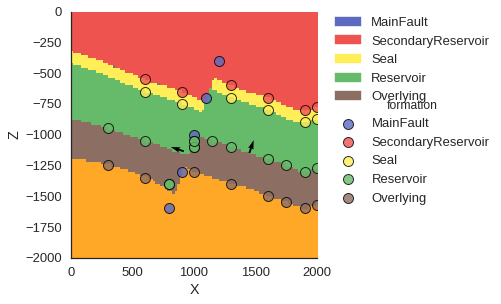

In [15]:
%matplotlib inline
gp.plot_section(geo_data, lith_block[0], 50, plot_data=True)

In [82]:
ver_s, sim_s = gp.get_surfaces(interp_data,lith_block[1],
                               fault_block[1],
                               original_scale=False)

In [83]:
gp.plot_surfaces_3D_real_time(interp_data, ver_s, sim_s)

# 2D plots

In [237]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)

In [238]:
# Some plotting options
params = {
    'axes.labelsize': 16,
    'font.size': 16,
    'legend.fontsize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    "axes.linewidth": 0.75,
    'xtick.major.size': 2,
    'xtick.major.width': 0.75,
    'ytick.major.size': 2,
    'ytick.major.width': 0.75,
}


def get_figsize(scale, textwidth=522, ratio=None):                      # Get this from LaTeX using \the\textwidth
    """Source: http://bkanuka.com/articles/native-latex-plots/"""
    inches_per_pt = 1.0 / 72.27                             # Convert pt to inch
    if ratio == None:
        ratio = (np.sqrt(5.0)-1.0)/2.0                    # Aesthetic ratio (you could change this)
    fig_width = textwidth * inches_per_pt * scale           # width in inches
    fig_height = fig_width * ratio                    # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

from matplotlib import rcParams
rcParams.update(params)

In [239]:
np.sort(vertices_list[0][1], axis=0)

array([[   0.        ,    0.        , -842.96844482],
       [   0.        ,    0.        , -842.96844482],
       [   0.        ,    0.        , -842.94883728],
       ...,
       [1980.        , 1980.        ,  -20.        ],
       [1980.        , 1980.        ,  -20.        ],
       [1980.        , 1980.        ,  -20.        ]])

In [240]:
vertices_list[0][1]

array([[  17.15488911,  140.        ,  -40.        ],
       [  20.        ,  140.        ,  -41.84677124],
       [  20.        ,  138.30210686,  -40.        ],
       ...,
       [1980.        , 1971.00234985, -200.        ],
       [1980.        , 1976.2197876 , -180.        ],
       [1980.        , 1980.        , -164.47387695]])

If a layer is folded through the axis x the plt.plot go nuts!!!

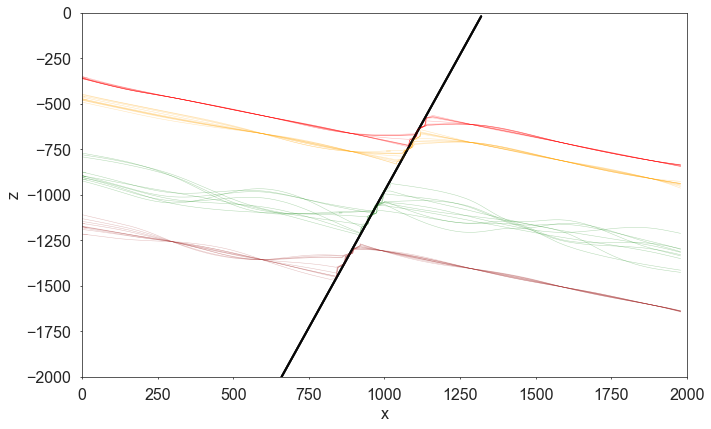

In [241]:
vertices = vertices_list

# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
   # f = vertices[i][l][:,1]==np.min(vertices[i][l][:,1])
   # f = a
    f = np.array(vertices[i][l][:,1] > 990) * np.array(vertices[i][l][:,1] < 1010)
    points = vertices[i][l][f]
    plt.plot(points[::1,0], points[::1,2], '-',
             #linestyle="solid",
             linewidth=lw, color=color, alpha=0.3)

fig = plt.figure(figsize=get_figsize(1.5))
ax = plt.subplot()
    
for i in range(0,len(vertices_list)):
    plot_iterline(i, 4, color="brown")
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.ylabel("z")
plt.xlim(0,2000)

plt.ylim(-2000,-0)

plt.grid(False)

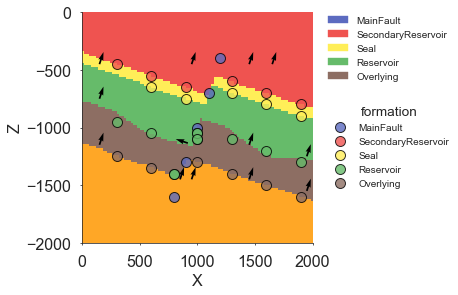

In [247]:
gp.plot_section(geo_data, lith_block[0], 50, plot_data=True)

### Prob

In [242]:
import gempy.UncertaintyAnalysisPYMC2 as uq
import importlib
importlib.reload(uq)

../gempy/UncertaintyAnalysisPYMC2.py:8: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


<module 'gempy.UncertaintyAnalysisPYMC2' from '../gempy/UncertaintyAnalysisPYMC2.py'>

In [243]:
p_i = uq.compute_prob_lith(lith_list)

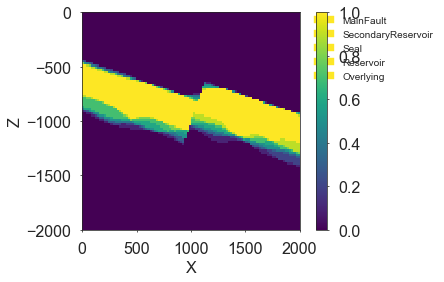

In [244]:
#previous vis does not work - conflict with cmaps...

plot_layer = 3

gp.plot_section(geo_data,p_i[plot_layer], 50, cmap='viridis', norm=None)
plt.colorbar()

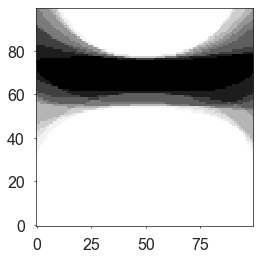

In [245]:
plt.imshow(p_i[3].reshape((100,100,100))[0].T, origin='upper left')

### Entropy

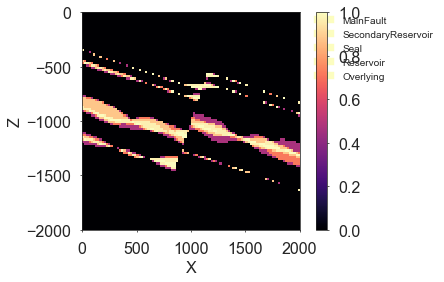

In [246]:

e = uq.calcualte_ie_masked(p_i)

gp.plot_section(geo_data,e, 50, cmap='magma', norm=None)
plt.colorbar()

## More vis options

Some more examples

In [50]:
vertices_list[0]

# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
   # f = vertices[i][l][:,1]==np.min(vertices[i][l][:,1])
   # f = a
    # FW: what does the next line do?
    f = np.array(vertices[i][l][:,1] > 980) * np.array(vertices[i][l][:,1] < 1020)
    points = vertices[i][l][f]
    plt.plot(points[::1,0], points[::1,2], '-',
             #linestyle="solid",
             linewidth=lw, color=color, alpha=0.3)



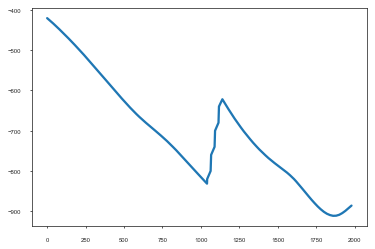

In [65]:
l=2
i=0
f = np.array(vertices[i][l][:,1] > 990) * np.array(vertices[i][l][:,1] < 1000)
points = vertices[i][l][f]
plt.plot(points[::1,0], points[::1,2])
# plt.plot(vertices_list[2][2][f][:,0], vertices_list[2][2][f][:,2])

In [111]:
# set maximum number of lines
n_max = 50 
# set number of lines in plot:
n_plot = 40
# set layer id:
l = 3

for i in range(1,50):
    if i > n_plot:
        plt.figure()
        for k in range(i-n_plot,i):
            f = np.array(vertices[i][l][:,1] > 980) * np.array(vertices[i][l][:,1] < 1020)
            points = vertices[i][l][f]
            # plt.plot(points[::1,0], points[::1,2], c='k', alpha=(k-i+n_plot+1)/n_plot, lw=0.1)
            plt.plot(points[::1,0], points[::1,2], '-', color=plt.cm.copper_r(i/n_plot), lw=0.1)
        plt.xlim(0,2000)
        plt.ylim(-2000,-0)        
        plt.savefig("./plots/line_plot_%03d.png" % i)
        plt.close()
    else:
        plt.figure()
        for k in range(i):
            f = np.array(vertices[i][l][:,1] > 980) * np.array(vertices[i][l][:,1] < 1020)
            points = vertices[i][l][f]
            # plt.plot(points[::1,0], points[::1,2], c='k', alpha=(k-i+n_plot+1)/n_plot, lw=0.1)
            plt.plot(points[::1,0], points[::1,2], '-', color=plt.cm.copper_r(i/n_plot), lw=0.1)
        plt.xlim(0,2000)
        plt.ylim(-2000,-0)        
        plt.savefig("./plots/line_plot_%03d.png" % i)
        plt.close()



In [97]:
i = 2
n_plot = 5

for k in range(i):
    print((k-i+n_plot+1)/n_plot)

0.8
1.0


In [120]:
# set maximum number of lines
n_max = 50 
# set number of lines in plot:
n_plot = 10
# set layer id:
l = 3

for i in range(1,50):
    if i > n_plot:
        plt.figure()
        for k in range(i-n_plot,i):
            f = np.array(vertices[i][l][:,1] > 980) * np.array(vertices[i][l][:,1] < 1020)
            # points = vertices[i][l][f]
            # plt.plot(points[::1,0], points[::1,2], c='k', alpha=(k-i+n_plot+1)/n_plot, lw=0.1)
            # plt.plot(points[::1,0], points[::1,2], '-', color=plt.cm.copper_r(i/n_plot), lw=0.1)
            plt.axhline(-k*10, color=plt.cm.copper_r(k/n_plot), lw=1.)
        plt.xlim(0,2000)
        plt.ylim(-2000,-0)        
        plt.savefig("./plots/line_plot_%03d.png" % i)
        plt.close()
    else:
        plt.figure()
        for k in range(i):
            f = np.array(vertices[i][l][:,1] > 980) * np.array(vertices[i][l][:,1] < 1020)
            points = vertices[i][l][f]
            # plt.plot(points[::1,0], points[::1,2], c='k', alpha=(k-i+n_plot+1)/n_plot, lw=0.1)
            # plt.plot(points[::1,0], points[::1,2], '-', color=plt.cm.copper_r(i/n_plot), lw=0.1)
            plt.axhline(-k*10, color=plt.cm.copper_r(k/n_plot), lw=1.)
        plt.xlim(0,2000)
        plt.ylim(-2000,-0)        
        plt.savefig("./plots/line_plot_%03d.png" % i, dpi=300)
        plt.close()




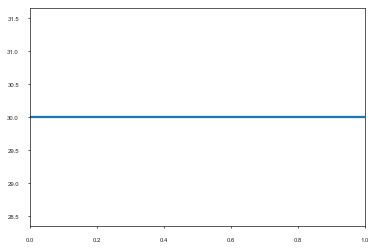

In [113]:
plt.axhline(30)

In [122]:
# set maximum number of lines
n_max = 50 
# set number of lines in plot:
n_plot = 10
# set layer id:
l = 3

for i in range(1,50):
    plt.figure()
    for k in range(n_plot):
        f = np.array(vertices[i][l][:,1] > 980) * np.array(vertices[i][l][:,1] < 1020)
        # points = vertices[i][l][f]
        # plt.plot(points[::1,0], points[::1,2], c='k', alpha=(k-i+n_plot+1)/n_plot, lw=0.1)
        # plt.plot(points[::1,0], points[::1,2], '-', color=plt.cm.copper_r(i/n_plot), lw=0.1)
        plt.axhline(-(i+k)*10, color=plt.cm.copper_r(k/n_plot), lw=1.)
    plt.xlim(0,2000)
    plt.ylim(-2000,-0)        
    plt.savefig("./plots/line_plot_%03d.png" % i)
    plt.close()




## Random realisations with smooth transitions

Similar to before, but now creating samples and then filling space in-between with continuous samples to enable a smooth transition:

In [298]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# n-random samples
n_rand = 4
# number of transition steps between realisations:
trans_steps = 5

# for now: only change reservoir top:
# determine ids of reservoir points:
res_ids = ori_data.interfaces['formation'] == 'Reservoir'
# get z_values from original model (for proper sampling):
z_vals_ori = ori_data.interfaces[res_ids]['Z']
# cast to array:
z_vals = np.array(z_vals_ori, dtype=np.float64)
# set stdev (consider ori val as mean):
z_res_stdev = 0.015

# list of all z_values:
z_values_all = []
# initialize with original model values:
z_values_all.append(z_vals)

# generate random samples:

z_vals_rand = []

z_vals_prev = z_vals.copy()
for i in range(n_rand):
    
    # ***** adjusted own implementation ****
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    
    z_vals_rand.append(z_vals_new)
    
    # fill space in-between:
    z_diff = (z_vals_new - z_vals_prev) / (trans_steps + 1)
    z_diff_array = np.cumsum(np.tile(z_diff, (trans_steps,1)), axis=0)
    for k in range(trans_steps):
        z_values_all.append(z_vals_prev + z_diff_array[k])
        
    # finally, add final value
    z_values_all.append(z_vals_new)
    # update prev array
    z_vals_prev = z_vals_new.copy()
        
    
    

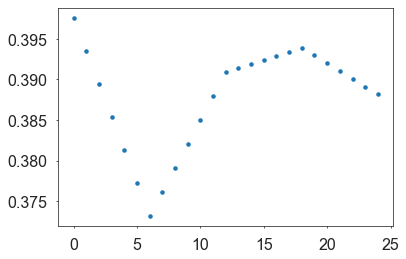

In [299]:
tmp = np.array(z_values_all)

plt.plot(tmp[:,0], '.')

## Next attempt: smooth random transitions with sigmoid function

In [304]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

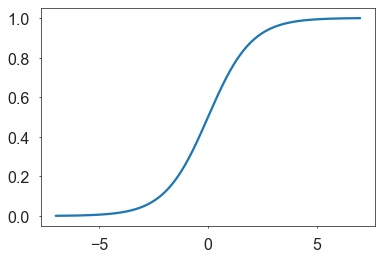

In [309]:
xvals = np.arange(-7,7,0.01)
plt.plot(xvals, sigmoid(xvals))

In [366]:
import matplotlib.pyplot as plt
import pandas as pd
import pyevtk as evtk

# n-random samples
n_rand = 50
# number of transition steps between realisations:
trans_steps = 15


# define sigomid steps - same for all:
sigmoid_steps = sigmoid(np.linspace(-5,5,trans_steps))

# for now: only change reservoir top:
# determine ids of reservoir points:
res_ids = ori_data.interfaces['formation'] == 'Reservoir'
# get z_values from original model (for proper sampling):
z_vals_ori = ori_data.interfaces[res_ids]['Z']
# cast to array:
z_vals = np.array(z_vals_ori, dtype=np.float64)
# set stdev (consider ori val as mean):
z_res_stdev = 0.01

# list of all z_values:
z_values_all = []
# initialize with original model values:
z_values_all.append(z_vals)

# generate random samples:

z_vals_rand = []

z_vals_prev = z_vals.copy()
for i in range(n_rand):
    
    # ***** adjusted own implementation ****
    # draw new values:
    z_vals_new = nrand.normal(loc=z_vals, scale=z_res_stdev)
    
    z_vals_rand.append(z_vals_new)
    
    # fill space in-between:
    z_diff = (z_vals_new - z_vals_prev) #  (trans_steps + 1)
    
    # tile sigmoid function:
    sigmoid_vals = np.tile(sigmoid_steps, (len(z_diff),1))
    z_diff_array = np.multiply(sigmoid_vals.T, z_diff)
    
    # z_diff_array = np.cumsum(np.tile(z_diff, (trans_steps,1)), axis=0)
    for k in range(trans_steps):
        z_values_all.append(z_vals_prev + z_diff_array[k])
        
    # finally, add final value
    z_values_all.append(z_vals_new)
    # update prev array
    z_vals_prev = z_vals_new.copy()
        
    
    

In [367]:
sigmoid_vals = np.tile(sigmoid_steps, (5,1))
diff = np.arange(1,6)
z = np.multiply(sigmoid_vals.T, diff)

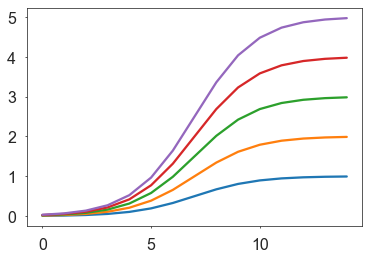

In [368]:
plt.plot(z)

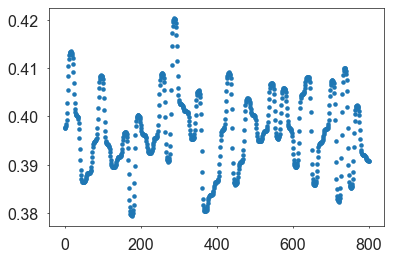

In [369]:
tmp = np.array(z_values_all)

plt.plot(tmp[:,0], '.')

In [370]:
# Lists for probability and ploting vertices
lith_list = np.zeros((0, lith_block[0].shape[-1]), dtype='int')
vertices_list = []
z_vals_list = []
for i in range(len(z_values_all)):
    
    # **** previous version by Miguel ****
    # Changing the interp
#     interp_data.geo_data_res.interfaces['Z'] = interp_data.geo_data_res.interfaces['Z'] + \
#                                              np.ones_like(interp_data.geo_data_res.interfaces['Z'])*0.001* np.random.choice([-1,1],
#                                              size = interp_data.geo_data_res.interfaces['Z'].shape[0])
        
    

    # assign values to data:
    interp_data.geo_data_res.interfaces.loc[
        interp_data.geo_data_res.interfaces['formation'] == 'Reservoir','Z'] \
        = z_values_all[i]
#     interp_data.geo_data_res.interfaces[res_ids]['Z'].set_values(z_vals_new)
#     new_df = pd.DataFrame({'Z' : z_vals_new})
#     interp_data.geo_data_res.interfaces[res_ids].update(new_df)
        
    # testing
    # print(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Reservoir']['Z'][:3])
    # print(z_vals_new[:3])
    
    # Compute
    lith_block, fault_block = gp.compute_model(interp_data)
    
    # Vertices
    ver, sim = gp.get_surfaces(interp_data,lith_block[1], fault_block[1], original_scale=True)
    
    lith_list = np.vstack((lith_list,lith_block[0]))
    vertices_list.append(ver)
    
    # Exporting both lith block and surfaces. name goes after path: This is because of how paraview reads numbers to define frames
    gp.export_to_vtk(geo_data, path='./vtks/', name='m'+str(i), lith_block=lith_block[0], vertices=ver,
                    simplices=sim)
    
    print(i)
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [371]:
np.sort(vertices_list[0][1], axis=0)

array([[   0.        ,    0.        , -836.36535645],
       [   0.        ,    0.        , -836.36535645],
       [   0.        ,    0.        , -836.10397339],
       ...,
       [1980.        , 1980.        ,  -20.        ],
       [1980.        , 1980.        ,  -20.        ],
       [1980.        , 1980.        ,  -20.        ]])

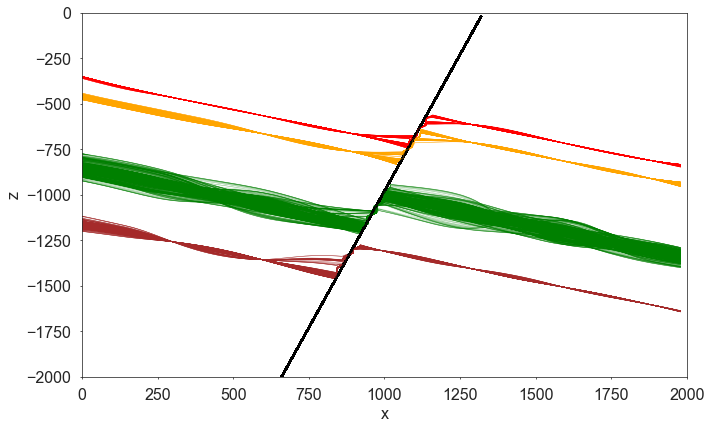

In [372]:
vertices = vertices_list

# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
   # f = vertices[i][l][:,1]==np.min(vertices[i][l][:,1])
   # f = a
    f = np.array(vertices[i][l][:,1] > 990) * np.array(vertices[i][l][:,1] < 1010)
    points = vertices[i][l][f]
    plt.plot(points[::1,0], points[::1,2], '-',
             #linestyle="solid",
             linewidth=lw, color=color, alpha=0.3)

fig = plt.figure(figsize=get_figsize(1.5))
ax = plt.subplot()
    
for i in range(0,len(vertices_list)):
    plot_iterline(i, 4, color="brown")
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.ylabel("z")
plt.xlim(0,2000)

plt.ylim(-2000,-0)

plt.grid(False)

## Just some side computations below

In [300]:
a = [1,5,2]
n_steps = 10

a_all = []
a_all.append(a[0])

a_prev = a[0]

all_vals = []

for a1 in a[1:]:
    a_diff = (a1 - a_prev) / n_steps
    a_diff_array = np.cumsum(np.tile(a_diff, (n_steps,1)), axis=0)
    # a_diff_array = np.linspace(a_prev, a1)
    trans = a_prev + np.array(a_diff_array)
    for t in trans:
        a_all.append(t)
    a_prev = a1
        

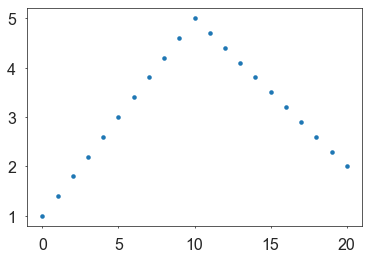

In [303]:
plt.plot(a_all, '.')

Using a sigmoid function instead (for smoother transitions):

$$S(x) = \frac{e^x}{e^x + 1}$$

In [327]:
a = [1,5,2]
n_steps = 10

a_all = []
a_all.append(a[0])

a_prev = a[0]

all_vals = []

# define sigomid steps - same for all:
sigmoid_steps = sigmoid(np.linspace(-5,5,n_steps))

for a1 in a[1:]:
    # determine scale
    a_diff = a1 - a_prev
    a_diff_array = a_diff * sigmoid_steps
    # a_diff_array = np.linspace(a_prev, a1)
    trans = a_prev + np.array(a_diff_array)
    for t in trans:
        a_all.append(t)
    a_prev = a1
        

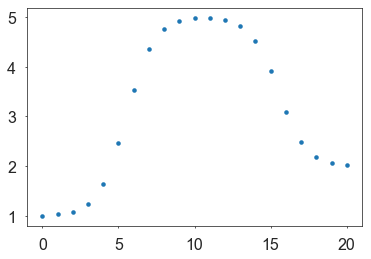

In [328]:
plt.plot(a_all, '.')

In [376]:
gp.plot_surfaces_3D(geo_data, ver, sim)